In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Functions for the bias correction bootstrap

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
#input event studies data and possible effect size, outputs 1 estimate
def h0_outcome(Y,effect):
    sample_size = len(Y)
    boot = np.random.choice(Y[:-1],sample_size)
    boot[-1] = boot[-1]+effect
    
    pre_mean = boot[:-1].mean()
    pre_sd = boot[:-1].std()
    est_effect = boot[-1]-pre_mean
    
    if est_effect < 1.65*pre_sd/np.sqrt(sample_size):
        return 0.0
    else:
        return est_effect

#input event studies data and possible effect size, outputs no_sims estimates
def h0_bias(Y,effect,no_sims):
    sim_df = pd.DataFrame(columns =['sim','est_effect'])
    sim_df['sim'] = range(1,no_sims)
    sim_df['est_effect'] = sim_df['sim'].apply(lambda s: h0_outcome(Y,effect) )
    
    rejected_mean = sim_df[['est_effect']].query('est_effect !=0').mean()[0]
    return rejected_mean

#input event studies data and range of possible effect sizes [lower, upper], outputs no_sims estimates 
def h0_bias_range(Y,no_sims, lower,upper):
    bias_df = pd.DataFrame(columns = ['effect','biased_effect'])
    bias_df['effect'] = np.linspace(lower,upper,25)
    bias_df['biased_effect'] = bias_df['effect'].apply(lambda s: h0_bias(Y,s,no_sims))
    
    return bias_df

#estimates the bias correction
# def true_effect_est(Y,lower,upper,no_sims):
#     est_effect = Y[-1]-Y[:-1].mean()
    
#     bias_df = h0_bias_range(Y,no_sims,lower,upper)
    
#     closest_est = find_nearest( bias_df['biased_effect'], est_effect)
#     de_biased_est = bias_df[ bias_df['biased_effect'] == closest_est]['effect'].values[0]
#     return de_biased_est

In [4]:
def h0_reject(Y):
    sample_size = len(Y)
    pre_mean = np.array(Y[0:-1]).mean()
    pre_sd = np.array(Y[0:-1]).std()
    
    delta = Y[-1] - pre_mean
    reject_threshold = 1.65*pre_sd * np.sqrt( (sample_size-1)/sample_size) 
    
    if delta > reject_threshold:
        return 'reject'
    else:
        return 'no_reject'

In [5]:
def biased_effect_est(Y, possible_effects, no_sims):
    sample_size = len(Y)
    sim_df = pd.DataFrame(columns = ['possible_effect','reject_count','reject_sum','average_rejected'])
    sim_df['possible_effect'] = possible_effects
    
    sim_df = sim_df.set_index('possible_effect')
    sim_df['reject_count'] = 0
    sim_df['reject_sum'] = 0
    
    for r in range(0,no_sims):
        boot = np.random.choice(Y[:-1],sample_size)
        pre_mean = boot[:-1].mean()
        pre_sd = boot[:-1].std()
        
        delta = boot[-1]-pre_mean
        reject_threshold = 1.65*pre_sd * np.sqrt( (sample_size-1)/sample_size) 
        
        for effect in possible_effects:
            if (delta + effect) > reject_threshold:
                sim_df.loc[effect,'reject_count'] = sim_df.loc[effect,'reject_count']+1
                sim_df.loc[effect,'reject_sum'] = sim_df.loc[effect,'reject_sum'] + (delta+effect)
    
    sim_df['average_rejected'] = sim_df['reject_sum']/sim_df['reject_count']
    
    return sim_df

def true_effect_est(Y,possible_effects,no_sims):
    est_effect = Y[-1]-Y[:-1].mean()
    
    bias_df = biased_effect_est(Y,possible_effects,no_sims).reset_index()
    
    closest_est = find_nearest( bias_df['average_rejected'], est_effect)
    de_biased_est = bias_df[ bias_df['average_rejected'] == closest_est]['possible_effect'].values[0]
    return de_biased_est

# Demonstration on a single data set (true effect 3, s.d. =1, n=9)

## Sample Data

Statistical inference on H0 is  reject


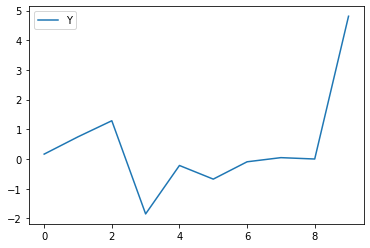

In [6]:
true_effect = 3

Y = np.random.normal(0,1,9)
Y = np.append(Y, np.random.normal(true_effect,1,1)[0])
print('Statistical inference on H0 is ', h0_reject(Y))

pd.DataFrame({'Y':Y}).plot()
plt.show()

### Plot of (Possible True Effect, Average Est. Effect of Rejected Samples)

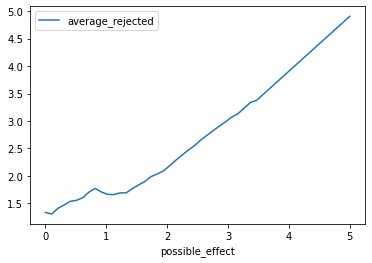

In [7]:
sample_bias_df = biased_effect_est(Y, np.linspace(0,5,50), 100).reset_index()

sample_bias_df.plot(x='possible_effect',y='average_rejected')
plt.show()

#### Implied Bias Correction based on above chart

In [8]:
est_effect = Y[-1]-np.array(Y[0:-1]).mean()

print('The naive estimate of effect size here is ',est_effect)
print('')
print( 'The bias-corrected estimate is ' ,true_effect_est(Y, np.linspace(0,5,50), 200) )

The naive estimate of effect size here is  4.87261025421519

The bias-corrected estimate is  4.8979591836734695


## Simulations for many samples (true effect = 2, s.d. =1, n=9)

In [26]:
true_effect = 2.0
sim_two_df = pd.DataFrame(columns = ['est_effect','bias_corrected'])

for r in range(1, 50):
    Y = np.random.normal(0,1,9)
    Y = np.append(Y, np.random.normal(true_effect,1,1)[0])
    
    if h0_reject(Y) == 'reject':
        est_effect = Y[-1]-np.array(Y[0:-1]).mean()
        bias_correct_est = true_effect_est(Y, np.linspace(1,5,40), 50)
        
        sim_two_df.loc[r] = [est_effect, bias_correct_est]

In [27]:
print('The average naive estimate for effect size was ',sim_two_df['est_effect'].mean())
print('')
print('The average biased-corrected estimate was ', sim_two_df['bias_corrected'].mean() )

The average naive estimate for effect size was  2.4663340938780514

The average biased-corrected estimate was  2.0256410256410247


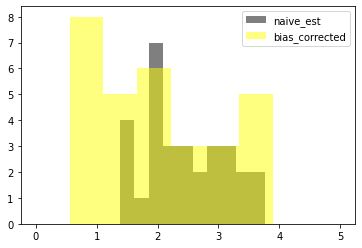

In [28]:
fig, ax = plt.subplots()

naive_est = sim_two_df['est_effect']
bias_correct_est = sim_two_df['bias_corrected']

bins = np.linspace(0,5,10)

plt.hist(naive_est , alpha=0.5, color = 'black', label = 'naive_est')
plt.hist(bias_correct_est,bins, alpha=0.5, color = 'yellow', label = 'bias_corrected')

plt.legend(loc='upper right')
plt.show()